In [1]:
import sqlite3 as db
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
database = "/home/sachin/Downloads/RWO_0004_Ventilatoren_00.sqlite"

con = db.connect(database)
df = pd.read_sql_query(f"SELECT time, value FROM Value WHERE sensor_id=2 AND "
                       f"time >= '{1619820000000}' AND time < '{1619848800000}'",
                       con)
df["time"] = df["time"].apply(lambda utc: datetime.fromtimestamp(int(utc / 1000)))
df.drop_duplicates(subset="time", keep="first", inplace=True)
df.index = df['time']
df.drop('time', axis=1, inplace=True)
df = df.reindex(pd.date_range(min(df.index),
                              max(df.index),
                              freq='S'))
df = df.interpolate().fillna(method='bfill')
con.close()

In [21]:
print(df)

                        value
2021-04-23 02:00:27  0.707373
2021-04-23 02:00:28  0.707377
2021-04-23 02:00:29  0.707381
2021-04-23 02:00:30  0.707386
2021-04-23 02:00:31  0.707390
...                       ...
2021-04-30 02:00:22  1.800430
2021-04-30 02:00:23  1.548030
2021-04-30 02:00:24  1.456980
2021-04-30 02:00:25  1.375830
2021-04-30 02:00:26  1.375100

[604800 rows x 1 columns]


In [ ]:
# import matplotlib.pyplot as plt
# df.plot()
# # plt.savefig('full_data_spikes_removed.eps', format='eps')


In [2]:
result = sm.tsa.stattools.adfuller(df["value"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.55433234620892
p-value: 3.3876226446107232e-21
Critial Values:
   1%, -3.430577482137719
Critial Values:
   5%, -2.861640540795267
Critial Values:
   10%, -2.566823514825133


In [ ]:
if result[1] < 0.05 and result[0] < result[4]['5%']:
    print("Stationary")
else:
    print("Non Stationary")

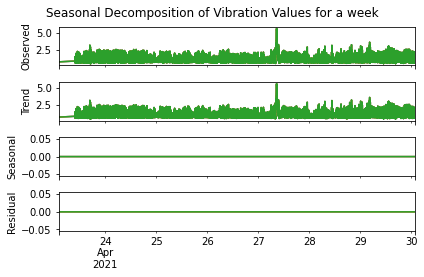

In [28]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
res=seasonal_decompose(df["value"], model='additive',period=1)
def plotseasonal(res):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(nrows=4, sharex=True)
fig.suptitle('Seasonal Decomposition of Vibration Values for a week')
plotseasonal(res)
plotseasonal(res)
plotseasonal(res)

plt.tight_layout(pad=1.08, rect=[0, 0.03, 1, 0.95])

# result.plot()
plt.savefig('decomposition.jpg', format='jpg', dpi=1200)

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as smt

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 1)
    #ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))

    #y.plot(ax=ts_ax)
    #p_value = sm.tsa.stattools.adfuller(y)[1]
    #ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.plot_acf(y, lags=lags, ax=acf_ax)
    smt.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(df['value'])

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.train, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

In [ ]:
test_len = int(len(df) * 0.2)
train, test = df.iloc[:-test_len], df.iloc[-test_len:]

# from sktime.forecasting.arima import AutoARIMA
#
# forecaster = AutoARIMA(start_p=2, max_p=5, suppress_warnings=True)
# train.index = train.index.astype(int)
# forecaster.fit(train)
# print(forecaster.summary())


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# fh = np.arange(test_len) + 1
# forecast = forecaster.predict(fh=fh, alpha=0.05)
# print(mean_squared_error(test, forecast))
from statsmodels.tsa.statespace.sarimax import SARIMAX



# from sktime.forecasting.arima import ARIMA
# model = ARIMA(train, (4,0,0)).fit()
# pred = model.predict(start=len(train))

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima.model import  import ARIMA
order = (4, 0, 0)
seasonal_order = (1, 1, 0, 60)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

In [ ]:
print(len(test))
yhat = results.forecast(steps = len(test))
print(yhat)
lm = pd.DataFrame(index=test.index)
lm['pred'] = yhat.values
lm['y'] = test['value']
print(lm)
plt.plot(lm)
plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.train, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

# print(mean_squared_error(test,yhat,squared=False))